<a href="https://colab.research.google.com/github/sergioGarcia91/ML_and_EDA/blob/main/05a_Fracturas_DecisionTreeRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree Regressor - Dataset: Fracturas Mesa de Los Santos

> *Ser tan rápidos como el más lento, \
> y ser tan lentos como el más rápido.*

**Autor:** Sergio Andrés García Arias  
**Versión 01:** Enero 2024

# Introducción

En este Notebook utilizaremos un algoritmo de regresión conocido como `Decision Tree Regressor`. Este algoritmo pertenece a la familia de los árboles de decisión, y es capaz de realizar predicciones supervisadas.

> **Observación:** Aunque en este Notebook nos enfocaremos directamente en el uso del `Decision Tree Regressor`, se recomienda realizar un Análisis Exploratorio de Datos (EDA). En un Notebook porterior, se realizará para proporciona una visión más profunda y comprensiva del conjunto de datos.

## ¿Cómo funciona?

El `Decision Tree Regressor` construye un modelo predictivo en forma de árbol, donde cada nodo interno representa una decisión basada en una característica específica, y cada hoja del árbol representa el valor de salida previsto. Durante la construcción del árbol, el algoritmo divide el conjunto de datos en subconjuntos más homogéneos, minimizando una métrica de error, como la varianza en el caso de la regresión.

<center>
<img src='https://upload.wikimedia.org/wikipedia/commons/c/c6/Manual_decision_tree.jpg' width=500 />

Tradicionalmente, los árboles de decisión eran creados manualmente. *Fuente: [Wikipedia](https://en.wikipedia.org/wiki/Decision_tree)*
</center>


# Inicio

In [1]:
!pip3 install contextily

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor # Para el arbol
from sklearn.model_selection import train_test_split # Para dividir en entrenamiento y prueba

import geopandas as gp
import contextily as cx #para el basemap en geopandas
import xyzservices.providers as xyz #para escoger el basemap

# Cargar Excel

In [3]:
# Esta vez es un archivo .xlsx
url = 'https://github.com/sergioGarcia91/ML_and_EDA/raw/main/Datasets/compiladoFinal_fracturas_INGEOMINAS_UIS_YC_SG.xlsx'
df = pd.read_excel(url)
df

X            Y  AZ BUZA  BUZA 
0     1109813.518  1252524.152      220     84
1     1109813.518  1252524.152      112     84
2     1109813.518  1252524.152      175     82
3     1109813.518  1252524.152      254     82
4     1109813.518  1252524.152      170     90
...           ...          ...      ...    ...
1485  1097631.000  1242705.000      335     20
1486  1099615.000  1240975.000      205     82
1487  1099615.000  1240975.000      275     78
1488  1105542.000  1236651.000      140     89
1489  1108441.000  1237821.000       60     81

[1490 rows x 4 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   X        1490 non-null   float64
 1   Y        1490 non-null   float64
 2   AZ BUZA  1490 non-null   int64  
 3   BUZA     1490 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 46.7 KB


In [5]:
df.describe()

X             Y      AZ BUZA        BUZA 
count  1.490000e+03  1.490000e+03  1490.000000  1490.000000
mean   1.109534e+06  1.249541e+06   180.795973    73.210738
std    5.018335e+03  4.883887e+03   107.414914    16.773044
min    1.097184e+06  1.236554e+06     1.000000     2.000000
25%    1.106530e+06  1.246239e+06    90.000000    68.000000
50%    1.108213e+06  1.250435e+06   185.500000    80.000000
75%    1.114950e+06  1.253293e+06   268.000000    85.000000
max    1.119550e+06  1.259950e+06   360.000000    90.000000

# Preparación Previa

Antes de iniciar el proceso de entrenamiento del modelo, vamos a realizar unos ajustes a los datos. En este contexto, nos proponemos predecir el rumbo de los planos de fracturas. Para lograrlo, llevaremos a cabo las siguientes modificaciones:

1. Ajuste de Azimut de Buzamiento: Los datos actualmente representan el azimut de buzamiento, por lo que se deben cambiar a azimut de rumbo.
2. Consideración de Valores entre 0° y 180°: Limitaremos nuestro análisis a valores de azimut de rumbo comprendidos entre 0° y 180°.


In [6]:
# Ajustar a azimut de rumbo restando 90
df['Az Rumbo'] = df['AZ BUZA'] - 90
df.describe()

X             Y      AZ BUZA        BUZA      Az Rumbo
count  1.490000e+03  1.490000e+03  1490.000000  1490.000000  1490.000000
mean   1.109534e+06  1.249541e+06   180.795973    73.210738    90.795973
std    5.018335e+03  4.883887e+03   107.414914    16.773044   107.414914
min    1.097184e+06  1.236554e+06     1.000000     2.000000   -89.000000
25%    1.106530e+06  1.246239e+06    90.000000    68.000000     0.000000
50%    1.108213e+06  1.250435e+06   185.500000    80.000000    95.500000
75%    1.114950e+06  1.253293e+06   268.000000    85.000000   178.000000
max    1.119550e+06  1.259950e+06   360.000000    90.000000   270.000000

In [7]:
# Tenemos valores negativos, puede que para nosotros es claro
# que abre a la izquierda el angulo
# pero mejor que quede expresado en valores entre 0 y 360
df['Az Rumbo'][df['Az Rumbo'] < 0] = df['Az Rumbo'][df['Az Rumbo'] < 0] + 360
df.describe()

<ipython-input-7-3b65e70d1d48>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Az Rumbo'][df['Az Rumbo'] < 0] = df['Az Rumbo'][df['Az Rumbo'] < 0] + 360


X             Y      AZ BUZA        BUZA      Az Rumbo
count  1.490000e+03  1.490000e+03  1490.000000  1490.000000  1490.000000
mean   1.109534e+06  1.249541e+06   180.795973    73.210738   180.433557
std    5.018335e+03  4.883887e+03   107.414914    16.773044   101.274524
min    1.097184e+06  1.236554e+06     1.000000     2.000000     0.000000
25%    1.106530e+06  1.246239e+06    90.000000    68.000000    95.000000
50%    1.108213e+06  1.250435e+06   185.500000    80.000000   177.500000
75%    1.114950e+06  1.253293e+06   268.000000    85.000000   270.000000
max    1.119550e+06  1.259950e+06   360.000000    90.000000   359.000000

In [8]:
# Ahora que queden entre 0 y 180
df['Az Rumbo'][df['Az Rumbo'] >= 180] = df['Az Rumbo'][df['Az Rumbo'] >= 180] - 180
df.describe()

<ipython-input-8-7593baefa981>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Az Rumbo'][df['Az Rumbo'] >= 180] = df['Az Rumbo'][df['Az Rumbo'] >= 180] - 180


X             Y      AZ BUZA        BUZA      Az Rumbo
count  1.490000e+03  1.490000e+03  1490.000000  1490.000000  1490.000000
mean   1.109534e+06  1.249541e+06   180.795973    73.210738    90.916779
std    5.018335e+03  4.883887e+03   107.414914    16.773044    48.535570
min    1.097184e+06  1.236554e+06     1.000000     2.000000     0.000000
25%    1.106530e+06  1.246239e+06    90.000000    68.000000    53.250000
50%    1.108213e+06  1.250435e+06   185.500000    80.000000    92.500000
75%    1.114950e+06  1.253293e+06   268.000000    85.000000   128.000000
max    1.119550e+06  1.259950e+06   360.000000    90.000000   179.000000

In [9]:
df.head()

X            Y  AZ BUZA  BUZA   Az Rumbo
0  1109813.518  1252524.152      220     84       130
1  1109813.518  1252524.152      112     84        22
2  1109813.518  1252524.152      175     82        85
3  1109813.518  1252524.152      254     82       164
4  1109813.518  1252524.152      170     90        80

# Train Test Split

In [10]:
# Vamos a tomar solo nuestras columnas de interés
X = df[['X', 'Y']].copy().to_numpy()
y = df['Az Rumbo'].copy().to_numpy()

# Datos entrenamiento = 80%
# Datos test  = 20%
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    train_size=0.8,
                                                    random_state=1)

X_train

array([[1106382.   , 1257532.   ],
       [1116394.994, 1246729.986],
       [1105542.   , 1236651.   ],
       ...,
       [1108528.   , 1259454.   ],
       [1106833.245, 1252064.902],
       [1106306.   , 1257520.   ]])

In [11]:
y_train = np.reshape(y_train, (-1,1))
y_train

array([[108],
       [160],
       [130],
       ...,
       [165],
       [168],
       [140]])

In [12]:
X_test

array([[1107491.716, 1253862.226],
       [1108087.   , 1258858.   ],
       [1118137.   , 1249537.   ],
       [1116033.758, 1246451.55 ],
       [1115930.966, 1247825.277],
       [1105688.   , 1249570.   ],
       [1098393.   , 1242714.   ],
       [1103334.   , 1255659.   ],
       [1115980.126, 1256526.146],
       [1098341.   , 1240598.   ],
       [1112921.   , 1251306.   ],
       [1108253.214, 1250434.805],
       [1115350.147, 1245772.735],
       [1109546.   , 1241174.   ],
       [1106834.   , 1250867.   ],
       [1106833.245, 1252064.902],
       [1106529.916, 1250828.168],
       [1114950.207, 1246238.579],
       [1117295.235, 1257135.599],
       [1107417.   , 1249274.   ],
       [1107006.698, 1252036.677],
       [1115826.   , 1247598.   ],
       [1112764.   , 1259066.   ],
       [1115925.385, 1247763.43 ],
       [1107491.716, 1253862.226],
       [1108253.214, 1250434.805],
       [1114960.   , 1246299.   ],
       [1108253.214, 1250434.805],
       [1113017.   ,

In [13]:
y_test = np.reshape(y_test, (-1, 1))
y_test

array([[107],
       [ 95],
       [  0],
       [166],
       [  0],
       [ 85],
       [100],
       [ 60],
       [110],
       [  5],
       [ 50],
       [ 86],
       [ 57],
       [ 99],
       [ 56],
       [ 11],
       [150],
       [132],
       [ 58],
       [ 85],
       [132],
       [130],
       [175],
       [169],
       [107],
       [ 80],
       [ 19],
       [ 12],
       [160],
       [146],
       [ 84],
       [ 69],
       [ 47],
       [147],
       [109],
       [  5],
       [ 80],
       [135],
       [153],
       [147],
       [179],
       [115],
       [ 22],
       [ 37],
       [127],
       [ 50],
       [123],
       [144],
       [115],
       [155],
       [ 60],
       [ 78],
       [106],
       [120],
       [107],
       [145],
       [140],
       [ 61],
       [152],
       [ 30],
       [165],
       [ 68],
       [171],
       [157],
       [ 76],
       [  5],
       [ 90],
       [ 42],
       [ 76],
       [114],
       [ 27],
      

# Entrenamiento

Para llevar a cabo el entrenamiento supervisado y predecir el rumbo del fracturamiento en la Mesa de Los Santos, haremos uso de la clase [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor) proporcionada por la biblioteca `Scikit-Learn`.

Con el objetivo de simplificar la configuración del modelo, nos enfocaremos únicamente en ajustar el parámetro `random_state`. Este parámetro garantiza la reproducibilidad de los resultados.


In [14]:
# Generar el modelo
modelo_DTR = DecisionTreeRegressor(random_state=0)

# Ajuste
modelo_DTR.fit(X_train, y_train)

# Puntaje
modelo_DTR.score(X_train, y_train)

0.23850001776796959

In [15]:
# Puntaje con los de test
modelo_DTR.score(X_test, y_test)

-0.29956073742160205

In [16]:
# Puntaje con todos
modelo_DTR.score(X, y)

0.1204006838720918

In [17]:
df['AR Pred'] = modelo_DTR.predict(X)
df.head()

X            Y  AZ BUZA  BUZA   Az Rumbo  AR Pred
0  1109813.518  1252524.152      220     84       130    105.8
1  1109813.518  1252524.152      112     84        22    105.8
2  1109813.518  1252524.152      175     82        85    105.8
3  1109813.518  1252524.152      254     82       164    105.8
4  1109813.518  1252524.152      170     90        80    105.8

In [18]:
df.describe()

X             Y      AZ BUZA        BUZA      Az Rumbo  \
count  1.490000e+03  1.490000e+03  1490.000000  1490.000000  1490.000000   
mean   1.109534e+06  1.249541e+06   180.795973    73.210738    90.916779   
std    5.018335e+03  4.883887e+03   107.414914    16.773044    48.535570   
min    1.097184e+06  1.236554e+06     1.000000     2.000000     0.000000   
25%    1.106530e+06  1.246239e+06    90.000000    68.000000    53.250000   
50%    1.108213e+06  1.250435e+06   185.500000    80.000000    92.500000   
75%    1.114950e+06  1.253293e+06   268.000000    85.000000   128.000000   
max    1.119550e+06  1.259950e+06   360.000000    90.000000   179.000000   

           AR Pred  
count  1490.000000  
mean     90.556131  
std      24.468538  
min       0.000000  
25%      79.000000  
50%      91.777778  
75%     105.800000  
max     175.000000

# Grid

Como parte del proceso analítico, procederemos a crear una grilla bidimensional que abarque las coordenadas X y Y, teniendo en cuenta los valores mínimos y máximos disponibles en el conjunto de datos. Esta grilla será fundamental para realizar estimaciones del rumbo del fracturamiento en cada punto de interés en la Mesa de Los Santos.

Posteriormente, emplearemos nuestro modelo previamente entrenado con `DecisionTreeRegressor` para realizar predicciones sobre esta grilla, obteniendo así estimaciones del rumbo de los planos de fracturas en cada ubicación específica.

In [19]:
Xmin = int(df['X'].min()/1000) * 1000
Xmax = (int(df['X'].max()/1000) * 1000) + 1000
Ymin = int(df['Y'].min()/1000) * 1000
Ymax = (int(df['Y'].max()/1000) * 1000) + 1000

print(Xmin)
print(Xmax)
print(Ymin)
print(Ymax)

1097000
1120000
1236000
1260000


In [20]:
delta = 200 # Cada cuantos metros un punto en X y Y
x = np.arange(Xmin, Xmax, delta)
y = np.arange(Ymin, Ymax, delta)
xv, yv = np.meshgrid(x, y, indexing='xy') # Vertices X Y

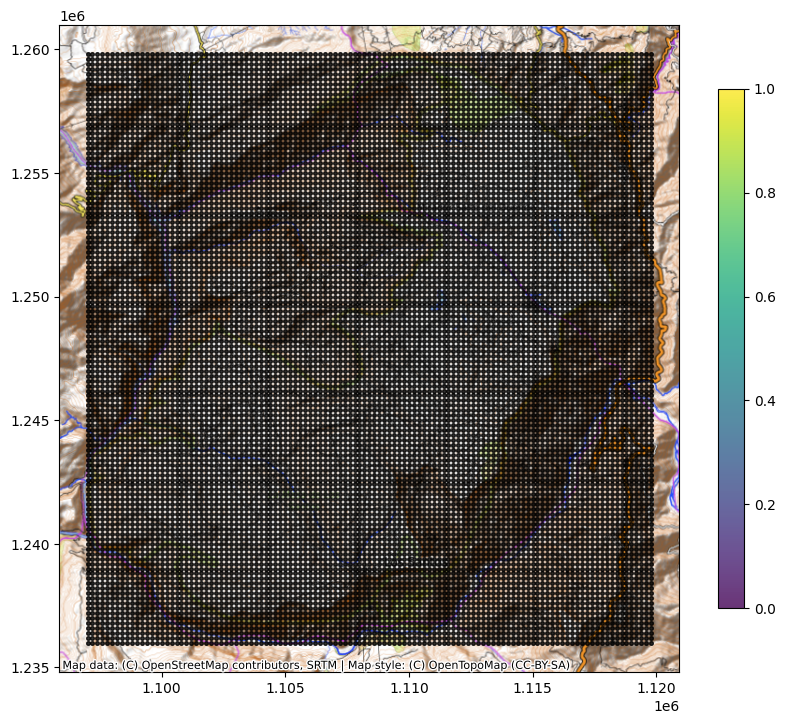

In [21]:
fig, ax = plt.subplots(figsize=(10,9))

puntos = ax.scatter(xv, yv,
                    c= 'k',
                    s=7,
                    alpha=0.8)

cx.add_basemap(ax=ax,
               crs='epsg:3116', # el sistema de coordenadas
               source=xyz.OpenTopoMap,
               reset_extent=True) # Para incluir un mapa base

plt.colorbar(mappable=puntos, shrink=0.75)

plt.show()

## Predicción

In [22]:
RumboPred = modelo_DTR.predict(np.concatenate((np.reshape(xv, (-1,1)), np.reshape(yv, (-1,1))), axis=1))
RumboPred = np.reshape(RumboPred, xv.shape)
RumboPred

array([[ 54.5 ,  54.5 ,  54.5 , ...,  54.5 ,  54.5 ,  54.5 ],
       [ 54.5 ,  54.5 ,  54.5 , ...,  54.5 ,  54.5 ,  54.5 ],
       [ 54.5 ,  54.5 ,  54.5 , ...,  54.5 ,  54.5 ,  54.5 ],
       ...,
       [ 56.  ,  56.  ,  56.  , ..., 108.75, 108.75, 108.75],
       [ 56.  ,  56.  ,  56.  , ..., 108.75, 108.75, 108.75],
       [ 56.  ,  56.  ,  56.  , ..., 108.75, 108.75, 108.75]])

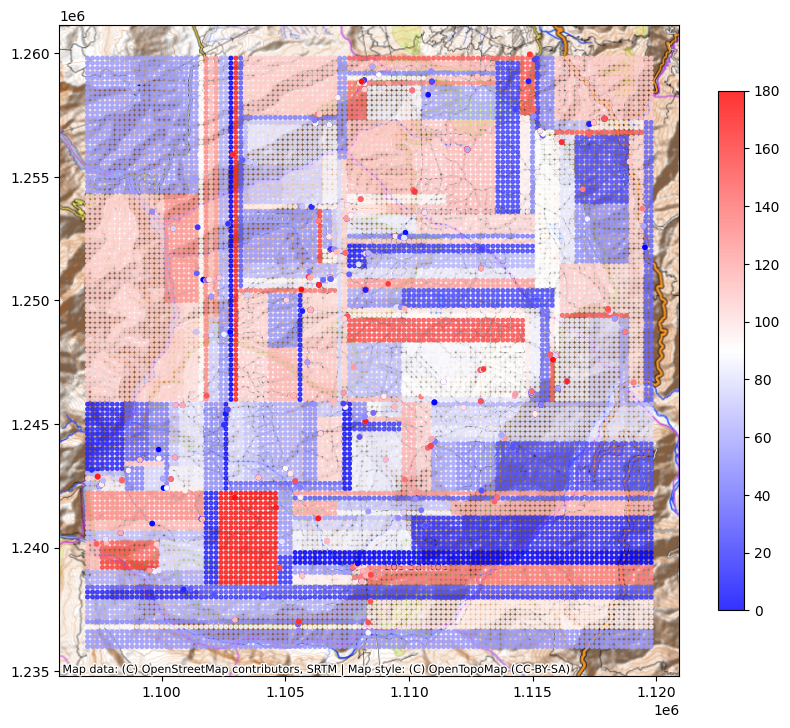

In [23]:
fig, ax = plt.subplots(figsize=(10,9))

puntos = ax.scatter(xv, yv,
                    c= RumboPred,
                    s=7,
                    cmap='bwr',
                    vmin=0,
                    vmax=180,
                    alpha=0.8)

ax.scatter(df['X'], df['Y'], # Puntos del Excel
           c= df['Az Rumbo'],
           s=10,
           cmap='bwr',
           vmin=0,
           vmax=180,
           alpha=1)

cx.add_basemap(ax=ax,
               crs='epsg:3116', # el sistema de coordenadas
               source=xyz.OpenTopoMap,
               reset_extent=True) # Para incluir un mapa base

plt.colorbar(mappable=puntos, shrink=0.75)

plt.show()

In [24]:
# Por Verificar:
# Se toma el azimut de buzamiento para que el 0 este en el E y no en el Norte
# se multiplica por -1 porque en geología abre en sentido de las manecillas del reloj
# y trigonometría es en sentido contrario ... desde el Este
df['Degrees'] = -1 * df['AZ BUZA']
df

X            Y  AZ BUZA  BUZA   Az Rumbo  AR Pred  Degrees
0     1109813.518  1252524.152      220     84       130    105.8     -220
1     1109813.518  1252524.152      112     84        22    105.8     -112
2     1109813.518  1252524.152      175     82        85    105.8     -175
3     1109813.518  1252524.152      254     82       164    105.8     -254
4     1109813.518  1252524.152      170     90        80    105.8     -170
...           ...          ...      ...    ...       ...      ...      ...
1485  1097631.000  1242705.000      335     20        65     65.0     -335
1486  1099615.000  1240975.000      205     82       115    115.0     -205
1487  1099615.000  1240975.000      275     78         5    115.0     -275
1488  1105542.000  1236651.000      140     89        50     90.0     -140
1489  1108441.000  1237821.000       60     81       150     95.0      -60

[1490 rows x 7 columns]

In [25]:
# Función para rotar un punto (x, y) alrededor del origen (0, 0)
# revisar ...
def rotate_point(x, # coordenada X de interes
                 y, # coordenada Y de interes
                 angle_degrees, # Az de Rumbo de la fractura
                 length):
                  # Longitud de la linea a gradicar

  angle_radians = np.radians(angle_degrees) # Se pasa a radianes

  # Matriz de rotacion
  # https://en.wikipedia.org/wiki/Rotation_matrix
  # Origen 0, 0
  x_rotated = (length/2) * np.cos(angle_radians) - 0 * np.sin(angle_radians)
  #x_rotated = x * np.cos(angle_radians) - y * np.sin(angle_radians)
  y_rotated = (length/2) * np.sin(angle_radians) + 0 * np.cos(angle_radians)
  #y_rotated = x * np.sin(angle_radians) + y * np.cos(angle_radians)

  # Movemos a las coordenadas de interes
  x1 = x + x_rotated
  x2 = x + (-1*x_rotated)

  y1 = y + y_rotated
  y2 = y + (-1*y_rotated)

  # Guardamos la línea
  x_rotated = [x1, x2]
  y_rotated = [y1, y2]
  return x_rotated, y_rotated

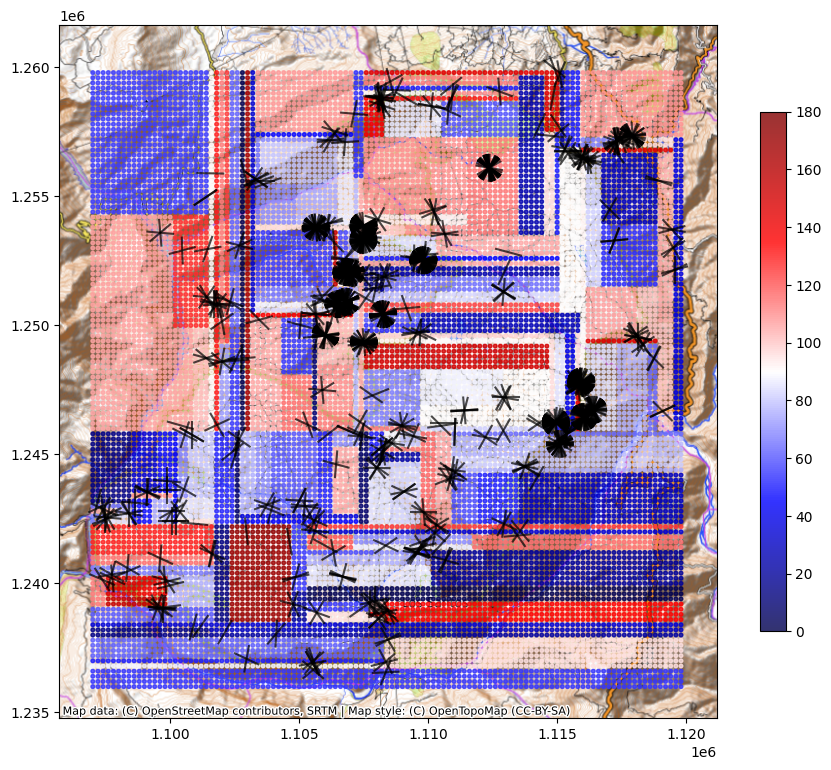

In [26]:
fig, ax = plt.subplots(figsize=(11,9))

puntos = ax.scatter(xv, yv,
                    c= RumboPred,
                    s=7,
                    cmap='seismic',
                    vmin=0,
                    vmax=180,
                    alpha=0.8)

# Representar cada punto como una línea rotada
for i in range(len(df)):
    x_rotated, y_rotated = rotate_point(df['X'][i], df['Y'][i], df['Degrees'][i], 1000)
    ax.plot(x_rotated, y_rotated, color='k', alpha=0.7)

cx.add_basemap(ax=ax,
               crs='epsg:3116', # el sistema de coordenadas
               source=xyz.OpenTopoMap,
               reset_extent=True) # Para incluir un mapa base

plt.colorbar(mappable=puntos, shrink=0.75)

plt.show()

# Observaciones

En este punto puede que tenga algunas conclusiones como interrogantes importantes derivados del análisis del modelo de `Decision Tree Regressor`:

- Las predicciones del modelo están limitadas al rango de 0 a 180 grados, sin la capacidad de predecir valores fuera de este intervalo. ¿Deberíamos considerar esta restricción como una ventaja que aporta consistencia o como una limitación que podría afectar la capacidad del modelo para capturar variaciones más allá de esos límites?
- En la representación gráfica del mapa, se observan áreas con forma de polígonos rectangulares que aparentar ser clusters. ¿Cómo interpretamos estas áreas y qué implicaciones podrían tener para la interpretación geológica? ¿Existen ajustes o técnicas adicionales que podrían mejorar la identificación de patrones espaciales más complejos?

- El modelo al parecer tiende a predecir únicamente una familia de diaclasas, mientras que en un afloramiento real podrían coexistir múltiples familias. ¿Cómo podríamos abordar esta limitación para que el modelo sea más versátil y capaz de reconocer la presencia de diversas familias de diaclasas en un mismo entorno geológico?

- La homogeneidad en los colores de los "polígonos" sugiere que, para un bloque dado, el valor predicho es uniforme, sin variaciones significativas. ¿Es esta uniformidad realista, o deberíamos considerar la posibilidad de introducir cierta variabilidad en la predicción para reflejar mejor la complejidad geológica?

---
Al utilizar el `Decision Tree Regressor`, es importante tener en cuenta algunas de sus limitaciones y consideraciones:


1. **Sensibilidad a Datos:** Los árboles de decisión son sensibles a pequeñas variaciones en los datos de entrada. Cambios mínimos pueden llevar a estructuras de árbol completamente diferentes. Aunque los árboles de decisión pueden modelar relaciones no lineales, pueden tener dificultades para capturar relaciones más complejas en comparación con modelos más avanzados.

2. **Sobreajuste (Overfitting):** Existe el riesgo de sobreajuste, especialmente en conjuntos de datos pequeños. Los árboles pueden memorizar el ruido en los datos, lo que resulta en un rendimiento deficiente en nuevos datos.

5. **Limitación en la Extrapolación:** Los árboles de decisión pueden no ser buenos para la extrapolación, es decir, hacer predicciones fuera del rango de los datos de entrenamiento.

3. **Univariedad de las Divisiones:** Los árboles de decisión tienden a realizar divisiones univariadas, lo que significa que cada nodo toma decisiones basadas en una única característica a la vez, pudiendo pasar por alto interacciones más complejas.

4. **Tuning de Parámetros:** Ajustar adecuadamente los parámetros, como la profundidad máxima del árbol, es esencial para controlar el sobreajuste y lograr un rendimiento óptimo.

5. **Preprocesamiento de Datos:**La calidad de las predicciones depende en gran medida de la calidad de los datos. Realizar un preprocesamiento adecuado y manejar valores atípicos es esencial.


# Fin